<br/>

$$ \huge{\underline{\textbf{ Artificial Neural Networks }}} $$

<br/>

<center>Example <b>ANN</b> implementation</center>
<center>corresponds to Sutton and Barto 2018, <b>chapter 9.7</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

In [503]:
class ANNFuncApprox():
    def __init__(self, learn_rate, min_state, max_state):
        """
        Params:
            learn_rate - step size, will be adjusted for nb_tilings automatically
            tile_size  - e.g. 200 for tiles to cover [1-200, 201-400, ...]
            nb_tilings - how many tiling layers
            nb_states  - total number of states, e.g. 1000
        """
        self._lr = learn_rate
        self._min_state = min_state
        self._max_state = max_state
        
        num_in = 1
        num_hid = 3
        num_out = 1
        
        # self._Wh = np.array([[1, -2, 0]])
        # self._bh = np.array([[15, -15, 0]])
        self._Wh = np.random.normal(loc=0, scale=1/num_in**-.5, size=[num_in,num_hid])
        self._bh = np.zeros(shape=[1, num_hid])
        
        # self._Wo = np.array([[3], [2], [0]])
        self._Wo = np.random.normal(loc=0, scale=1/num_hid**-.5, size=[num_hid, num_out])
        self._bo = np.zeros(shape=[1, num_out])
        
    def eval(self, state):
        if np.isscalar(state):
            state = np.array([[state]])  # convert scalar to 1-element matrix so matmuls work ok
        
        state_01 = (state-self._min_state) / (self._max_state-self._min_state)    # scale to range [0..1]
        state_11 = state_01 * 2 - 1                                               # scale to range [-1..1]
        
        
        y_hat, _, _ = ANNFuncApprox.forward(state_11, self._Wh, self._bh, self._Wo, self._bo)
        return float(y_hat)

        
    def train(self, state, target):
        if np.isscalar(state):
            state = np.array([[state]])
        if np.isscalar(target):
            target = np.array([[target]])
        
        state_01 = (state-self._min_state) / (self._max_state-self._min_state)    # scale to range [0..1]
        state_11 = state_01 * 2 - 1                                               # scale to range [-1..1]       
        
        dWh, dbh, dWo, dbo = ANNFuncApprox.backward(state_11, target, self._Wh, self._bh, self._Wo, self._bo)
        
#         # check gradients
#         ngWh, ngbh, ngWo, ngbo = ANNFuncApprox.num_grad(state_11, target, self._Wh, self._bh, self._Wo, self._bo)
#         assert np.allclose(dbo, ngbo)
#         assert np.allclose(dWo, ngWo)
#         assert np.allclose(dbh, ngbh)
#         assert np.allclose(dWh, ngWh)
        
        self._Wh += -self._lr * dWh
        self._bh += -self._lr * dbh
        self._Wo += -self._lr * dWo
        self._bo += -self._lr * dbo
        
    @staticmethod
    def forward(x, Wh, bh, Wo, bo):
        assert x.ndim == 2  # x must be 2d array, dims: [nb_samples, nb_features]
        z_hid = x @ Wh + bh                     # input to hidden layer
        h_hid = ANNFuncApprox.sigmoid(z_hid)    # output from hidden layer
        z_out = h_hid @ Wo + bo                 # input to output layer
        y_hat = z_out                           # output from outpu layer (linear activation)
        return y_hat, z_hid, h_hid              # z_hid, h_hid required for backprop
    
    @staticmethod
    def backward(x, y, Wh, bh, Wo, bo):
        y_hat, z_hid, h_hid = ANNFuncApprox.forward(x, Wh, bh, Wo, bo)
        
        ro_o = -1 * (y - y_hat)
        dWo = h_hid.T @ ro_o                      / len(x)
        dbo = np.sum(ro_o, axis=0, keepdims=True) / len(x)
        
        ro_h = ro_o @ Wo.T * ANNFuncApprox.sigmoid_deriv(z_hid)
        dWh = x.T @ ro_h                          / len(x)
        dbh = np.sum(ro_h, axis=0, keepdims=True) / len(x)
        
        return dWh, dbh, dWo, dbo
    
    @staticmethod
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def sigmoid_deriv(x):
        return ANNFuncApprox.sigmoid(x) * (1 - ANNFuncApprox.sigmoid(x))

    @staticmethod
    def loss(x, y, Wh, bh, Wo, bo):
        y_hat, _, _ = ANNFuncApprox.forward(x, Wh, bh, Wo, bo)
        return .5 * np.mean(np.sum((y - y_hat)**2, axis=-1))     # mean squared error
       
    @staticmethod
    def num_grad(x, y, Wh, bh, Wo, bo):
        eps = 1e-4
                
        dbo = np.zeros_like(bo)
        for c in range(bo.shape[1]):
            bo_plus = bo.copy(); bo_plus[0,c] += eps
            bo_min = bo.copy(); bo_min[0,c] -= eps
            loss_plus = ANNFuncApprox.loss(x, y, Wh, bh, Wo, bo_plus)
            loss_min = ANNFuncApprox.loss(x, y, Wh, bh, Wo, bo_min)
            dbo[0,c] = (loss_plus - loss_min) / (2*eps)
        
        dWo = np.zeros_like(Wo)
        for r in range(Wo.shape[0]):
            for c in range(Wo.shape[1]):
                Wo_plus = Wo.copy(); Wo_plus[r,c] += eps
                Wo_min = Wo.copy(); Wo_min[r,c] -= eps
                loss_plus = ANNFuncApprox.loss(x, y, Wh, bh, Wo_plus, bo)
                loss_min = ANNFuncApprox.loss(x, y, Wh, bh, Wo_min, bo)
                dWo[r,c] = (loss_plus - loss_min) / (2*eps)
                                
        dbh = np.zeros_like(bh)
        for c in range(bh.shape[1]):
            bh_plus = bh.copy(); bh_plus[0,c] += eps
            bh_min = bh.copy(); bh_min[0,c] -= eps
            loss_plus = ANNFuncApprox.loss(x, y, Wh, bh_plus, Wo, bo)
            loss_min = ANNFuncApprox.loss(x, y, Wh, bh_min, Wo, bo)
            dbh[0,c] = (loss_plus - loss_min) / (2*eps)
        
        dWh = np.zeros_like(Wh)
        for r in range(Wh.shape[0]):
            for c in range(Wh.shape[1]):
                Wh_plus = Wh.copy(); Wh_plus[r,c] += eps
                Wh_min = Wh.copy(); Wh_min[r,c] -= eps
                loss_plus = ANNFuncApprox.loss(x, y, Wh_plus, bh, Wo, bo)
                loss_min = ANNFuncApprox.loss(x, y, Wh_min, bh, Wo, bo)
                dWh[r,c] = (loss_plus - loss_min) / (2*eps)
                        
        return dWh, dbh, dWo, dbo

In [817]:
q_hat = ANNFuncApprox(learn_rate=0.01, min_state=-100, max_state=100)

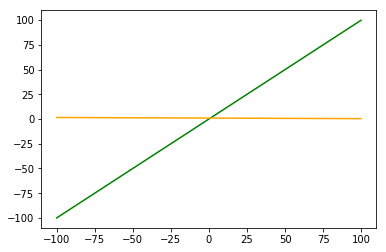

In [818]:
xx = np.arange(-100, 100, 0.1)
yy = xx # np.sin(xx/40)
ii = np.array(range(len(xx)))
yy_hat = np.zeros_like(yy)

for i in range(len(xx)):
    yy_hat[i] = q_hat.eval(xx[i])
    
plt.plot(xx, yy, color='green')
plt.plot(xx, yy_hat, color='orange')

In [ ]:
for i in range(2000):
    
    train_idx = np.random.choice(range(0,2000), 10)
    for ti in train_idx:
        q_hat.train(xx[ti], yy[ti])
    
    if i % 200 == 0:
        yy2 = []
        for j in np.arange(-100, 100, 0.1):
            yy2.append( q_hat.eval(j) )
        plt.plot(xx, yy, color='green')
        print(xx[i], yy[i])
        plt.scatter(xx[i], yy[i], color='red')
        plt.plot(xx, yy2, color='orange')
        plt.show()

-100.0 -100.0


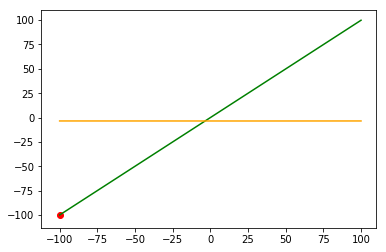

-80.00000000000114 -80.00000000000114


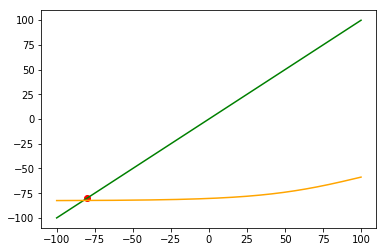

-60.000000000002274 -60.000000000002274


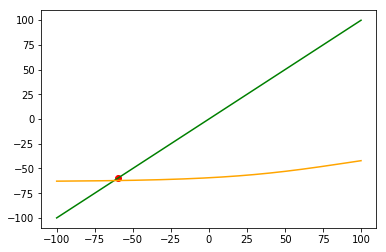

-40.00000000000341 -40.00000000000341


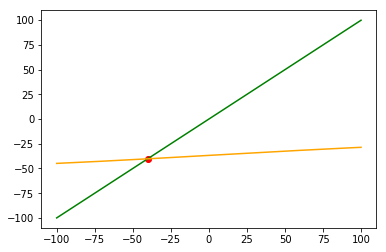

-20.000000000004547 -20.000000000004547


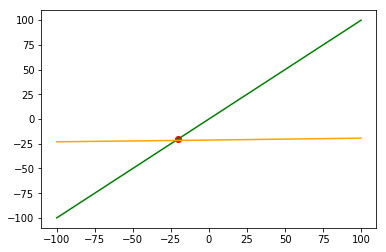

-5.6843418860808015e-12 -5.6843418860808015e-12


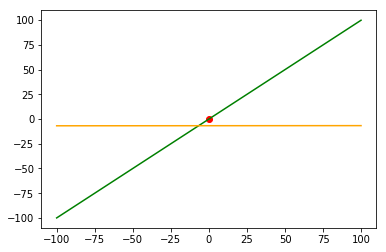

19.99999999999318 19.99999999999318


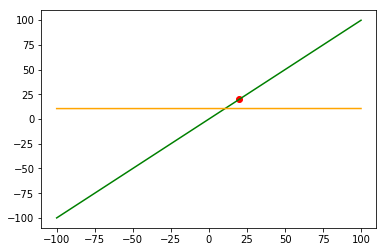

39.99999999999204 39.99999999999204


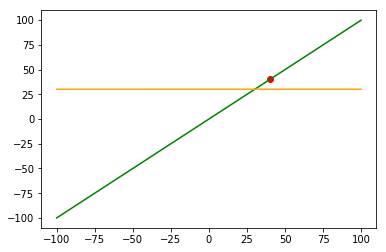

59.999999999990905 59.999999999990905


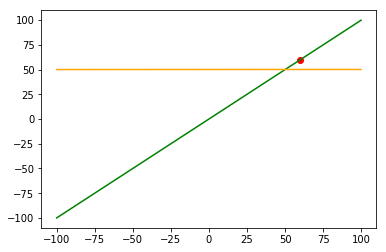

79.99999999998977 79.99999999998977


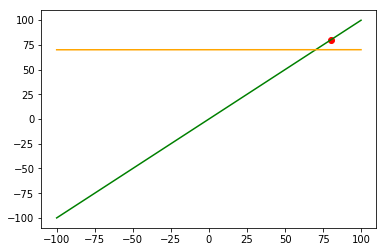

In [813]:
for i in range(2000):
    q_hat.train(xx[i], yy[i])
    if i % 200 == 0:
        yy2 = []
        for j in np.arange(-100, 100, 0.1):
            yy2.append( q_hat.eval(j) )
        plt.plot(xx, yy, color='green')
        print(xx[i], yy[i])
        plt.scatter(xx[i], yy[i], color='red')
        plt.plot(xx, yy2, color='orange')
        plt.show()

-100.0 -100.0


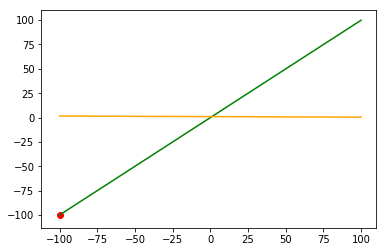

-80.00000000000114 -80.00000000000114


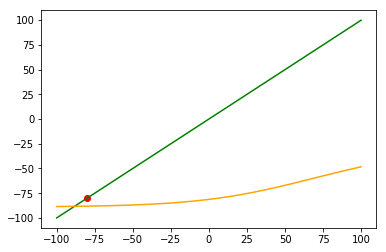

-60.000000000002274 -60.000000000002274


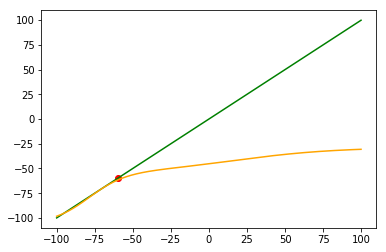

-40.00000000000341 -40.00000000000341


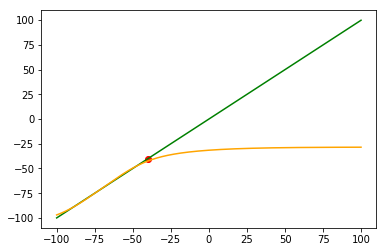

-20.000000000004547 -20.000000000004547


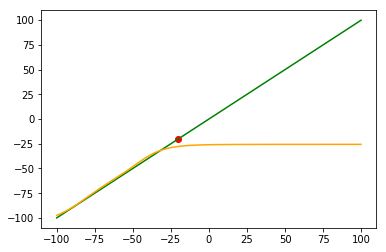

-5.6843418860808015e-12 -5.6843418860808015e-12


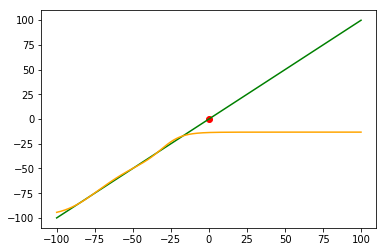

19.99999999999318 19.99999999999318


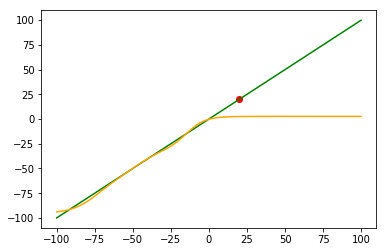

39.99999999999204 39.99999999999204


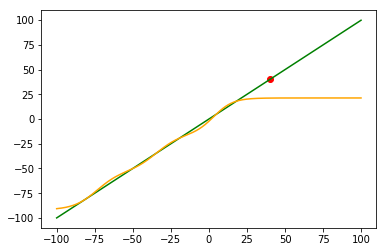

59.999999999990905 59.999999999990905


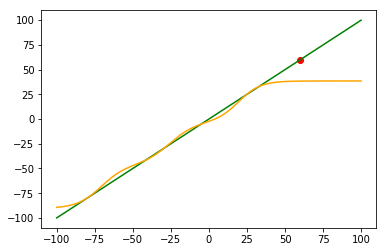

79.99999999998977 79.99999999998977


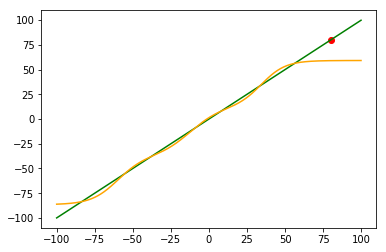

In [819]:
for i in range(2000):
    if i > 10:
        train_idx = np.random.choice(range(0,i), 10)
        for ti in train_idx:
            q_hat.train(xx[ti], yy[ti])
    
    if i % 200 == 0:
        yy2 = []
        for j in np.arange(-100, 100, 0.1):
            yy2.append( q_hat.eval(j) )
        plt.plot(xx, yy, color='green')
        print(xx[i], yy[i])
        plt.scatter(xx[i], yy[i], color='red')
        plt.plot(xx, yy2, color='orange')
        plt.show()

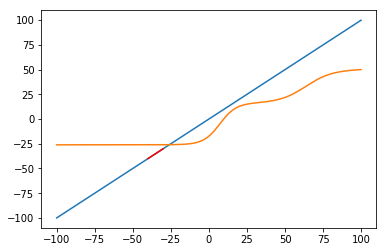

In [757]:
yy2 = []
for i in np.arange(-100, 100, 0.1):
    yy2.append( q_hat.eval(i) )
plt.plot(xx, yy)
plt.plot(xx[ist:ien], yy[ist:ien], color='red')
plt.plot(xx, yy2)

In [710]:
q_hat._lr = 0.01

In [500]:
def hoho(q_hat):
    pdb.set_trace()
    q_hat.train(25, -1)

In [507]:
hoho(q_hat)

> <ipython-input-500-81e517d4955f>(3)hoho()
-> q_hat.train(25, -1)
(Pdb) c


We are going to use Gradient MC algorithm from chapter 9.3 as a learning algorithm. Before continuing you should familiarise yourself properly with [chapter 9.3](0903a_Gradient_MC.ipynb). We will use the "fixed" version of Gradient MC, repeated here for reference.

One notable difference is that this version takes callback and trace arguments, so we can log results after each episode. This is used to reproduce figures in the book.

In [1]:
def gradient_MC(env, policy, ep, gamma, model, callback=None, trace=None):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env    - environment
        policy - function in a form: policy(state)->action
        ep     - number of episodes to run
        gamma  - discount factor [0..1]
        model  - function approximator, already initialised, with method:
                     train(state, target) -> None
        callback - function in a form: callback(episode, model, trace) -> None
        trace  - passed to callback, so it can log data into it
    """
    for e_ in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
            model.train(St, Gt)
               
        if callback is not None:
            callback(e_, model, trace)

In [2]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

---

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0910.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 9.10 - averaged over 10 runs. Data points were collected every 100 episodes.<center/></td>
    </tr>
</table>

I realise this does not reproduce figure from the book, currently I'm not sure how exactly figure in the book was obtained. I am confident it is not because number of runs I used is 10 instead of 30 like in the book, or because I calculated VE every 100 episodes.

The only alternative implementation I found is by Shangtong Zhang ([github](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction)). His graph looks a bit closer, but he decays step size over time, which obviously changes shape of curves. I modified his implementation to use fixed step size instead, and got same result as mine.

If anyone was able to reproduce results exactly (w/o adding/changing/removing anythign), please drop me a msg.

# Environment Setup

All environment and plotting code is exactly the same as in [chapter 9.3](0903a_Gradient_MC.ipynb). All the code is available here: [helpers_0905.py](helpers_0905.py)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from helpers_0905 import LinearEnv, plot_linear

In [4]:
env = LinearEnv()

In [5]:
def policy(st):
    return np.random.choice([0, 1])

# Tile Coding

In [13]:
class TileCodingFuncApprox():
    def __init__(self, learn_rate, tile_size, nb_tilings, nb_states):
        """
        Params:
            learn_rate - step size, will be adjusted for nb_tilings automatically
            tile_size  - e.g. 200 for tiles to cover [1-200, 201-400, ...]
            nb_tilings - how many tiling layers
            nb_states  - total number of states, e.g. 1000
        """
        self._lr = learn_rate / nb_tilings
        self._tile_size = tile_size
        self._nb_tilings = nb_tilings
        self._nb_states = nb_states
        
        # calculate total number of possible tiles so we can allocate memory
        # this calculation is valid for 1d space only!
        nb_tiles_to_cover_state_space = (nb_states // tile_size) + 1  # +1 because tiles
        num_tiles_total = nb_tiles_to_cover_state_space * nb_tilings  #    stick out on sides
        self._num_total_tiles = num_tiles_total

        self._iht = tiles3.IHT(num_tiles_total)  # index hash table
        self._w = np.zeros(num_tiles_total)      # weights
        
    def reset(self):
        self._iht = tiles3.IHT(self._num_total_tiles)  # clear index hash table
        self._w = np.zeros(self._num_total_tiles)      # clear weights
        
    def evaluate(self, state):
        st_scaled = (state-1) / self._tile_size        # scale state to map to tiles correctly
        tile_indices = tiles3.tiles(self._iht,
                                    numtilings=self._nb_tilings,
                                    floats=[st_scaled])
        
        # Implementation #1
        return np.sum(self._w[tile_indices])           # pick correct weights and sum up
        
        # Implementation #2                            # as lin. comb., equivalent to #1
#         x = np.zeros(self._num_total_tiles)
#         x[tile_indices] = 1
#         return x @ self._w
        
        
    def train(self, state, target):
        st_scaled = (state-1) / self._tile_size        # scale state to map to tiles correctly
        tile_indices = tiles3.tiles(self._iht, 
                                    numtilings=self._nb_tilings,
                                    floats=[st_scaled])
        value = np.sum(self._w[tile_indices])
        self._w[tile_indices] += self._lr * (target - value)  # update active weights

Quick test: **one** set of tiles dividing states into groups of size **200** eacg

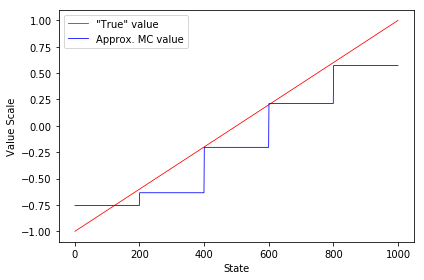

In [14]:
model = TileCodingFuncApprox(learn_rate=0.001, tile_size=200, nb_tilings=1, nb_states=1001)
gradient_MC(env, policy, ep=1000, gamma=1.0, model=model)
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env=env)

Quick test #2: now with **four** sets of tiles, each offset by 1/4 of tile width

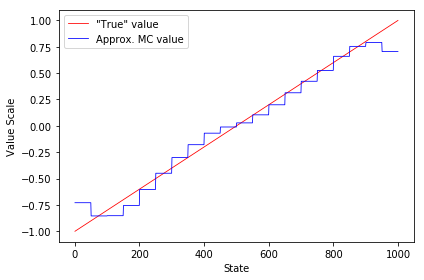

In [17]:
model = TileCodingFuncApprox(learn_rate=0.001, tile_size=200, nb_tilings=4, nb_states=1001)
gradient_MC(env, policy, ep=1000, gamma=1.0, model=model)
V = [model.evaluate(st) for st in range(1001)]
plot_linear(V, env=env)

# Reproduce Figure 9.10

Callback is called by *gradient_MC* every single timestep:
* only process every 100th episode (speed)
* compute V for all states
* compute Root Mean Squared Error (skip terminal state 0, state 1001 is out of boundry)
* append to *rmse* list

In [18]:
def callback(episode, model, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    if episode % 100 != 0:    return
    V = np.array([model.evaluate(st) for st in range(1001)])                   # arr of float
    err = np.sqrt(np.mean(np.power((np.array(V[1:]) - env.V_approx[1:]), 2)))  # float
    trace.append(err)

Define experiment

In [19]:
def experiment(runs, env, policy, ep, gamma, model, callback):
    results = []  # dims: [nb_runs, nb_episodes]
    for r in range(runs):
        trace = []  # dim: [nb_episodes]
        model.reset()
        gradient_MC(env, policy, ep, gamma, model, callback=callback, trace=trace)
        results.append(trace)
    return np.average(results, axis=0)

Compute result for tilings=1. Average over 10 runs. This took ~6min.

In [276]:
ts = time.time()
model_1 = TileCodingFuncApprox(learn_rate=0.0001, tile_size=200, nb_tilings=1, nb_states=1001)
tiles_1 = experiment(10, env, policy, ep=10000, gamma=1.0, model=model_1, callback=callback)
print('Time took:', time.time()-ts)

Time took: 363.76061820983887


And for tilings=50. Not that alpha is automatically divided by nb_tilings, so we are still in line with the book.

In [280]:
ts = time.time()
model_50 = TileCodingFuncApprox(learn_rate=0.0001, tile_size=200, nb_tilings=50, nb_states=1001)
tiles_50 = experiment(10, env, policy, ep=10000, gamma=1.0, model=model_50, callback=callback)
print('Time took:', time.time()-ts)

Time took: 979.4627282619476


Plot results

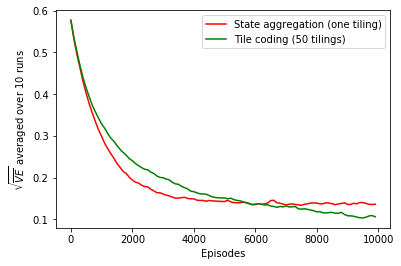

In [305]:
fig = plt.figure()
ax = fig.add_subplot(111)
xx = np.array(range(len(tiles_1))) * 100
ax.plot(xx, tiles_1, color='red', label='State aggregation (one tiling)')
ax.plot(xx, tiles_50, color='green', label='Tile coding (50 tilings)')
ax.set_ylabel('$\sqrt{\overline{VE}}$ averaged over 10 runs')
ax.set_xlabel('Episodes')
# plt.savefig('assets/fig_0910.png')
ax.legend()
plt.show()

And plot final values for V

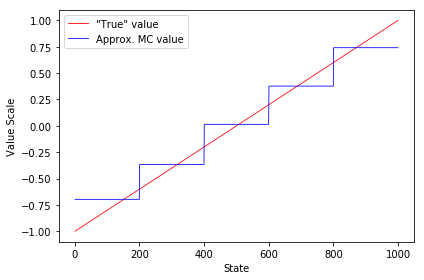

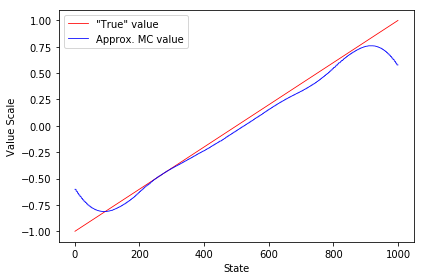

In [25]:
V_1 = [model_1.evaluate(st) for st in range(1001)]
V_50 = [model_50.evaluate(st) for st in range(1001)]

plot_linear(V_1, env)
plot_linear(V_50, env)